In [1]:
%load_ext autoreload
%autoreload 2
%cd ../notebooks/..

/home/jry/source/jaroslavknotek/python-baraky


/home/jry/source/jaroslavknotek/python-baraky/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import baraky.io as io
from baraky.client import SrealityEstatesClient

query_params = await io.read_json('query_params.json')
client = SrealityEstatesClient(query_params)

In [3]:
from baraky.estate_features import PIDCommuteFeatureEnhancer

feature_calculators = {"pid_commute_time": PIDCommuteFeatureEnhancer()}

In [4]:
import asyncio
estates =  await client.read_all()

In [5]:
len(estates)

2543

In [7]:
from tqdm.auto import tqdm
for name, calculator in feature_calculators.items():
    for estate in tqdm(estates):
        await asyncio.sleep(.1)
        feature_data = await calculator.calculate(estate)
        estate.features[name] = feature_data

/home/jry/source/jaroslavknotek/python-baraky/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2543/2543 [1:56:56<00:00,  2.76s/it]


In [8]:
estates[0]

EstateOverview(link='https://www.sreality.cz/detail/prodej/dum/rodinny/habartov-kluc-tylova/1700241996', price=5998000, id='1700241996', gps=(50.19083, 12.560943), features={'commute_time': PIDCommuteFeature(time_minutes=153, transfers_count=1, from_station='Karlovy Vary,terminál', to_station='Smíchovské nádraží', gps_stop_distance=0.30598082403967786)})

In [17]:
invalid = [e for e in estates if e.features["commute_time"].time_minutes is None]
len(invalid)

723

In [26]:
from baraky.models import EstateOverview

def _filter_close_to_prague(
    estate_overview: EstateOverview, commute_time: PIDCommuteFeatureEnhancer
):
    if commute_time.time_minutes is None:
        return False
    is_close = commute_time.time_minutes < 60
    max_1_transfer = commute_time.transfers_count <=1
    return max_1_transfer and is_close and estate_overview.price < 10_000_000 

def _filter(estate_overview):
    commute_time = estate_overview.features.get("commute_time")
    return _filter_close_to_prague(estate_overview,commute_time)

near = list(filter(_filter,estates))
print(len(near))

28


In [133]:
ids

['3395958092',
 '3469305676',
 '3008143948',
 '3544999244',
 '4004607308',
 '2940601676',
 '3281425740',
 '1762252108',
 '4020835660',
 '2542182988',
 '1521984076',
 '1243903308',
 '2039309644',
 '1431197004',
 '3269833292',
 '1222488652',
 '2430362956',
 '2282271308',
 '3339235916',
 '915031372',
 '3314902348',
 '4110206284',
 '1949328716',
 '71791948',
 '4281120076',
 '4228871244',
 '3149792332',
 '1806173260']

In [134]:
from baraky.storages import MinioStorage

from minio.deleteobjects import DeleteObject
minio_storage = MinioStorage()

ids = [e.id for e in near]
delete_objs = [DeleteObject(f"estate/house/{id}.json") for id in ids]
errors = minio_storage.client.remove_objects(
    "estates",
    delete_objs
)

for e in errors:
    print(e)
#minio_storage.client.


(array([2., 2., 1., 4., 0., 6., 3., 4., 2., 4.]),
 array([4990000., 5490000., 5990000., 6490000., 6990000., 7490000.,
        7990000., 8490000., 8990000., 9490000., 9990000.]),
 <BarContainer object of 10 artists>)

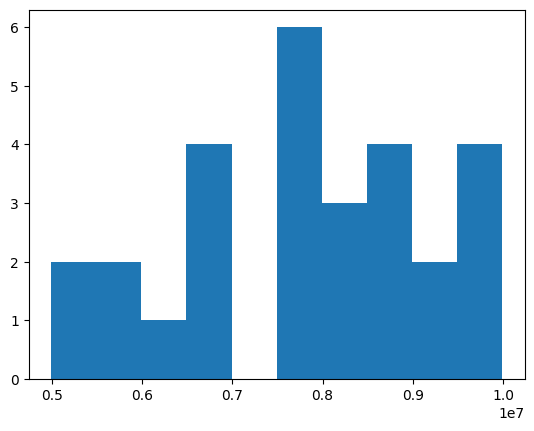

In [29]:
import matplotlib.pyplot as plt
prices = [e.price for e in near]
plt.hist(prices)

(array([1., 1., 1., 0., 1., 4., 6., 4., 2., 8.]),
 array([18. , 22.1, 26.2, 30.3, 34.4, 38.5, 42.6, 46.7, 50.8, 54.9, 59. ]),
 <BarContainer object of 10 artists>)

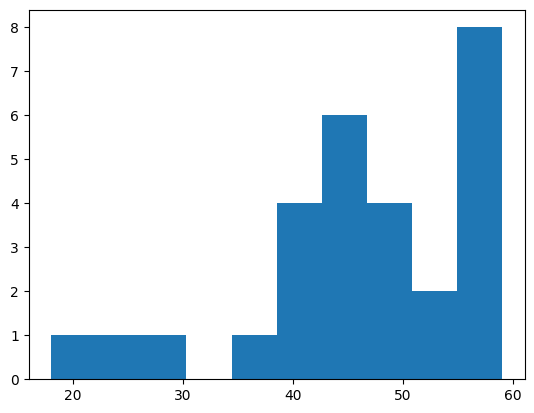

In [31]:
minutes = [e.features['commute_time'].time_minutes for e in near]
plt.hist(minutes)

In [ ]:
import pandas as pd
pd.set_option('max_colwidth', None)

df = pd.DataFrame([n.dict() for n in near])

list(df['gps'])

In [39]:
model

EstateOverview(link='https://www.sreality.cz/detail/prodej/dum/rodinny/klucov-klucov-/3395958092', price=7499000, id='3395958092', gps=(50.094635, 14.908324), features={'pid_commute_time': PIDCommuteFeature(time_minutes=57, transfers_count=1, from_station='Klučov,U mlýna', to_station='Smíchovské nádraží', gps_stop_distance=0.0029290124615650747)})

In [41]:
model = EstateQueueMessage.map_from_estate_overview(near[0])

In [118]:
from baraky.models import EstateQueueMessage

In [111]:
import baraky.queue

In [120]:
queue.put(near[0])

In [ ]:
from pydantic import ValidationError
from baraky.queue import RabbitQueueConsumer
from baraky.models import EstateQueueMessage

def callback(ch, method, properties, body):
    try:
        model = EstateQueueMessage.model_validate_json(body)
    except ValidationError:
        logging.exception("Error validating message %s",body)
        return

    print(model)

consumer = RabbitQueueConsumer('estates_hits')
consumer.listen(callback)

link='https://www.sreality.cz/detail/prodej/dum/rodinny/trnova-trnova-/2940601676' price=9990000 id='2940601676' pid_commute_time_min=25 transfers_count=1 station_nearby='Trnová (PZ)'
link='https://www.sreality.cz/detail/prodej/dum/rodinny/velky-chlumec--/2542182988' price=6700000 id='2542182988' pid_commute_time_min=56 transfers_count=1 station_nearby='Velký Chlumec,II'
link='https://www.sreality.cz/detail/prodej/dum/rodinny/klucov-klucov-/3395958092' price=7499000 id='3395958092' pid_commute_time_min=57 transfers_count=1 station_nearby='Klučov,U mlýna'
link='https://www.sreality.cz/detail/prodej/dum/rodinny/jiloviste--/4004607308' price=9490000 id='4004607308' pid_commute_time_min=18 transfers_count=0 station_nearby='Jíloviště,Rozcestí Trnová'
link='https://www.sreality.cz/detail/prodej/dum/rodinny/daleke-dusniky-druhlice-/2039309644' price=9950000 id='2039309644' pid_commute_time_min=55 transfers_count=1 station_nearby='Daleké Dušníky,Druhlice'
link='https://www.sreality.cz/detail/p